In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from google.colab import drive
import cv2
import os
from pathlib import Path
from tqdm import tqdm
import json

import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive and setup
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("✅ PyTorch setup complete!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
✅ PyTorch setup complete!


In [2]:
def Load_MammographyData():
    """Load mammography dataset with improved data analysis"""
    base_path = '/content/drive/MyDrive/Mammography  cleaned dataset'

    X_train = np.load(f"{base_path}/X_train.npy")
    y_train = np.load(f"{base_path}/y_train.npy")
    X_test = np.load(f"{base_path}/X_test.npy")
    y_test = np.load(f"{base_path}/y_test.npy")

    try:
        cleaned_data = pd.read_csv(f"{base_path}/cleaned_data.csv")
    except:
        print("⚠️ Could not load CSV file, continuing without it")
        cleaned_data = None

    print(f"✅ Data loaded successfully!")
    print(f"Training data shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Test labels shape: {y_test.shape}")

    # Convert multi-class to binary classification
    y_train_binary = (y_train > 0).astype(np.float32)
    y_test_binary = (y_test > 0).astype(np.float32)

    print(f"Original classes - Train: {np.unique(y_train)}, Test: {np.unique(y_test)}")
    print(f"Binary classes - Train: {np.unique(y_train_binary)}, Test: {np.unique(y_test_binary)}")

    # Ensure images are in correct format and normalized
    if len(X_train.shape) == 3:
        X_train = np.expand_dims(X_train, axis=-1)
    if len(X_test.shape) == 3:
        X_test = np.expand_dims(X_test, axis=-1)

    # CRITICAL FIX: Proper normalization
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # Normalize to [0, 1] if not already
    if X_train.max() > 1.0:
        X_train = X_train / 255.0
        X_test = X_test / 255.0

    print(f"Corrected data shapes: X_train: {X_train.shape}, X_test: {X_test.shape}")
    print(f"Data ranges: X_train [{X_train.min():.3f}, {X_train.max():.3f}], X_test [{X_test.min():.3f}, {X_test.max():.3f}]")

    # Check binary class distribution
    unique_train, counts_train = np.unique(y_train_binary, return_counts=True)
    unique_test, counts_test = np.unique(y_test_binary, return_counts=True)

    print(f"\n📊 Binary Training class distribution:")
    for label, count in zip(unique_train, counts_train):
        class_name = "Normal" if label == 0 else "Abnormal"
        print(f"  {class_name} (Class {int(label)}): {count} samples ({count/len(y_train_binary)*100:.1f}%)")

    print(f"\n📊 Binary Test class distribution:")
    for label, count in zip(unique_test, counts_test):
        class_name = "Normal" if label == 0 else "Abnormal"
        print(f"  {class_name} (Class {int(label)}): {count} samples ({count/len(y_test_binary)*100:.1f}%)")

    return X_train, y_train_binary, X_test, y_test_binary, cleaned_data


In [3]:
# Load data
X_train, y_train, X_test, y_test, cleaned_data = Load_MammographyData()

✅ Data loaded successfully!
Training data shape: (2854, 224, 224)
Training labels shape: (2854,)
Test data shape: (714, 224, 224)
Test labels shape: (714,)
Original classes - Train: [0 1 2], Test: [0 1 2]
Binary classes - Train: [0. 1.], Test: [0. 1.]
Corrected data shapes: X_train: (2854, 224, 224, 1), X_test: (714, 224, 224, 1)
Data ranges: X_train [0.008, 0.984], X_test [0.008, 0.984]

📊 Binary Training class distribution:
  Normal (Class 0): 1163 samples (40.7%)
  Abnormal (Class 1): 1691 samples (59.3%)

📊 Binary Test class distribution:
  Normal (Class 0): 266 samples (37.3%)
  Abnormal (Class 1): 448 samples (62.7%)


In [4]:
class MammographyDataset(Dataset):
    """Improved dataset class with better preprocessing"""
    def __init__(self, images, labels, transform=None, is_training=False):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].copy()
        label = self.labels[idx]

        # Handle different image formats
        if len(image.shape) == 3 and image.shape[-1] == 1:
            image = image.squeeze(-1)

        # Ensure image is float32 and in [0, 1]
        if image.dtype != np.float32:
            image = image.astype(np.float32)

        # Convert to PIL-like tensor format (C, H, W)
        image = torch.FloatTensor(image).unsqueeze(0).repeat(3, 1, 1)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor
        label = torch.FloatTensor([float(label)])

        return image, label


In [5]:
def create_data_loaders(X_train, y_train, X_test, y_test, batch_size=32, val_split=0.2):
    """Create improved data loaders"""

    # Stratified validation split
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=val_split, stratify=y_train, random_state=42
    )

    print(f"📋 Data split:")
    print(f"Training: {len(X_train_split)} samples")
    print(f"Validation: {len(X_val)} samples")
    print(f"Test: {len(X_test)} samples")

    # MUCH gentler augmentation for medical images
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=3),  # Very small rotation
        transforms.ColorJitter(brightness=0.05, contrast=0.05),  # Very gentle
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create datasets
    train_dataset = MammographyDataset(X_train_split, y_train_split,
                                     transform=train_transform, is_training=True)
    val_dataset = MammographyDataset(X_val, y_val, transform=val_test_transform)
    test_dataset = MammographyDataset(X_test, y_test, transform=val_test_transform)

    # FIXED: Better balanced sampling
    class_counts = np.bincount(y_train_split.astype(int))
    total_samples = len(y_train_split)

    # Calculate weights to balance classes
    weights = total_samples / (len(class_counts) * class_counts)
    sample_weights = [weights[int(label)] for label in y_train_split]

    sampler = WeightedRandomSampler(weights=sample_weights,
                                   num_samples=len(sample_weights),
                                   replacement=True)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                             sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                           shuffle=False, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader, weights


In [6]:
# Create data loaders
train_loader, val_loader, test_loader, class_weights = create_data_loaders(
    X_train, y_train, X_test, y_test
)

📋 Data split:
Training: 2283 samples
Validation: 571 samples
Test: 714 samples


In [7]:
class SimpleMammographyCNN(nn.Module):
    """Simpler, more stable CNN architecture"""
    def __init__(self, num_classes=1, dropout_rate=0.3):
        super(SimpleMammographyCNN, self).__init__()

        # Feature extractor
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.15),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((4, 4))
        )

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),

            nn.Linear(128, num_classes)
        )

        # Initialize weights properly
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [8]:
class StableTransferLearningCNN(nn.Module):
    """More stable transfer learning model"""
    def __init__(self, num_classes=1, dropout_rate=0.4):
        super(StableTransferLearningCNN, self).__init__()

        # Use ResNet18 for better stability
        self.backbone = models.resnet18(pretrained=True)

        # Remove the final layer
        self.backbone.fc = nn.Identity()

        # Simple but effective classifier
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.25),
            nn.Linear(32, num_classes)
        )

        # Freeze backbone initially
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Initialize classifier weights
        self._initialize_classifier()

    def _initialize_classifier(self):
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

    def unfreeze_backbone_gradually(self, stage=1):
        """Gradually unfreeze backbone layers"""
        if stage == 1:
            # Unfreeze layer4
            for param in self.backbone.layer4.parameters():
                param.requires_grad = True
        elif stage == 2:
            # Unfreeze layer3 and layer4
            for param in self.backbone.layer3.parameters():
                param.requires_grad = True
            for param in self.backbone.layer4.parameters():
                param.requires_grad = True


In [9]:
def focal_loss(inputs, targets, alpha=0.25, gamma=2.0):
    """Focal loss for handling class imbalance"""
    bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    pt = torch.exp(-bce_loss)
    focal_loss = alpha * (1 - pt) ** gamma * bce_loss
    return focal_loss.mean()


In [17]:
def train_model_stable(model, train_loader, val_loader, num_epochs=30,
                      learning_rate=0.001, class_weights=None, use_focal=True):
    """Stable training with better monitoring"""

    model = model.to(device)

    # Use focal loss or weighted BCE
    if use_focal:
        criterion = focal_loss
        print("Using Focal Loss for class imbalance")
    else:
        if class_weights is not None:
            pos_weight = torch.tensor([class_weights[1] / class_weights[0]],
                                    dtype=torch.float32).to(device)
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
            print(f"Using weighted BCE with pos_weight: {pos_weight.item():.3f}")
        else:
            criterion = nn.BCEWithLogitsLoss()
            print("Using standard BCE loss")

    # Optimizer with proper weight decay
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                           weight_decay=0.01, eps=1e-8)

    # More stable scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-7
    )

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'lr': []
    }

    best_val_acc = 0.0
    best_val_auc = 0.0
    patience_counter = 0
    max_patience = 10

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        train_pbar = tqdm(train_loader, desc=f'Training Epoch {epoch+1}')
        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            # Calculate loss
            if use_focal:
                loss = criterion(outputs, labels)
            else:
                loss = criterion(outputs, labels)

            # Check for invalid loss
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss at epoch {epoch}, batch {batch_idx}")
                continue

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Statistics
            train_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Update progress bar
            current_lr = optimizer.param_groups[0]['lr']
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{train_correct/train_total:.3f}',
                'LR': f'{current_lr:.6f}'
            })

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_val_probs = []
        all_val_labels = []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Validation Epoch {epoch+1}')
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)

                if use_focal:
                    loss = criterion(outputs, labels)
                else:
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                predicted = (probs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

                # Store for AUC calculation
                all_val_probs.extend(probs.cpu().numpy().flatten())
                all_val_labels.extend(labels.cpu().numpy().flatten())

                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{val_correct/val_total:.3f}'
                })

        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        # Calculate validation AUC
        try:
            fpr, tpr, _ = roc_curve(all_val_labels, all_val_probs)
            val_auc = auc(fpr, tpr)
        except:
            val_auc = 0.5

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')

        # Save best model based on AUC (more reliable than accuracy for imbalanced data)
        if val_auc > best_val_auc and val_auc > 0.6:  # Only save if AUC is reasonable
            best_val_auc = val_auc
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_mammography_model.pth')
            print(f'✅ New best model saved! Val AUC: {val_auc:.4f}, Val Acc: {val_acc:.4f}')
            patience_counter = 0
        else:
            patience_counter += 1

        # Learning rate scheduling
        scheduler.step(val_auc)

        # Early stopping
        if patience_counter >= max_patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return history


In [12]:
def evaluate_model_comprehensive(model, test_loader, threshold=0.5):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.sigmoid(outputs)

            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    y_true = np.array(all_labels).flatten()
    y_pred_proba = np.array(all_probabilities).flatten()
    y_pred = (y_pred_proba > threshold).astype(int)

    # Calculate metrics with proper error handling
    try:
        accuracy = np.mean(y_pred == y_true)
        precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
        recall = recall_score(y_true, y_pred, average='binary', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0)
    except:
        accuracy = precision = recall = f1 = 0.0

    # ROC and PR AUC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = auc(recall_curve, precision_curve)
    except:
        roc_auc = pr_auc = 0.5
        fpr = tpr = np.array([0, 1])
        precision_curve = recall_curve = np.array([0, 1])

    # Print results
    print("Classification Report:")
    try:
        print(classification_report(y_true, y_pred,
                                   target_names=['Normal', 'Abnormal'],
                                   zero_division=0))
    except:
        print("Could not generate classification report")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Abnormal'],
                yticklabels=['Normal', 'Abnormal'],
                ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_ylabel('True Label')
    axes[0, 0].set_xlabel('Predicted Label')

    # ROC Curve
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC Curve (AUC = {roc_auc:.3f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend(loc="lower right")

    # Precision-Recall Curve
    axes[1, 0].plot(recall_curve, precision_curve, color='red', lw=2,
                    label=f'PR Curve (AUC = {pr_auc:.3f})')
    axes[1, 0].set_xlim([0.0, 1.0])
    axes[1, 0].set_ylim([0.0, 1.05])
    axes[1, 0].set_xlabel('Recall')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Precision-Recall Curve')
    axes[1, 0].legend(loc="lower left")

    # Prediction Distribution
    axes[1, 1].hist(y_pred_proba[y_true == 0], alpha=0.5, label='Normal', bins=30)
    axes[1, 1].hist(y_pred_proba[y_true == 1], alpha=0.5, label='Abnormal', bins=30)
    axes[1, 1].axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold}')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Prediction Distribution')
    axes[1, 1].legend()

    plt.tight_layout()
    plt.show()

    print(f"\n📊 Final Metrics:")
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-Score: {f1:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"PR AUC: {pr_auc:.3f}")

    return accuracy, roc_auc, precision, recall, f1


In [13]:
def find_optimal_threshold_stable(model, val_loader):
    """Find optimal threshold using validation set"""
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs).flatten()
    all_labels = np.array(all_labels).flatten()

    # Try different thresholds
    thresholds = np.arange(0.1, 0.9, 0.02)
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        predictions = (all_probs > threshold).astype(int)
        try:
            f1 = f1_score(all_labels, predictions, average='binary')
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        except:
            continue

    print(f"🎯 Optimal threshold: {best_threshold:.3f} (F1-score: {best_f1:.3f})")
    return best_threshold


In [ ]:
# def plot_training_history(history):
#     """Enhanced training history plotting"""
#     fig, axes = plt.subplots(2, 2, figsize=(15, 10))

#     # Accuracy plot
#     axes[0, 0].plot(history['train_acc'], label='Training', marker='o', linewidth=2)
#     axes[0, 0].plot(history['val_acc'], label='Validation', marker='s', linewidth=2)
#     axes[0, 0].set_title('Model Accuracy Over Time', fontsize=14)
#     axes[0, 0].set_xlabel('Epoch')
#     axes[0, 0].set_ylabel('Accuracy')
#     axes[0, 0].legend()
#     axes[0, 0].grid(True, alpha=0.3)

#     # Loss plot
#     axes[0, 1].plot(history['train_loss'], label='Training', marker='o', linewidth=2)
#     axes[0, 1].plot(history['val_loss'], label='Validation', marker='s', linewidth=2)
#     axes[0, 1].set_title('Model Loss Over Time', fontsize=14)
#     axes[0, 1].set_xlabel('Epoch')
#     axes[0, 1].set_ylabel('Loss')
#     axes[0, 1].legend()
#     axes[0, 1].grid(True, alpha=0.3)

#     # Learning rate
#     axes[1, 0].plot(history['lr'], 'g-', linewidth=2)
#     axes[1, 0].set_title('Learning Rate Schedule', fontsize=14)
#     axes[1, 0].set_xlabel('Epoch')
#     axes[1, 0].set_ylabel('Learning Rate')
#     axes[1, 0].grid(True, alpha=0.3)

#     # Summary
#     axes[1, 1].axis('off')
#     best_val_acc = max(history['val_acc'])
#     best_val_epoch = history['val_acc'].index(best_val_acc) + 1
#     final_train_acc = history['train_acc'][-1]
#     final_val_acc = history['val_acc'][-1]

#     summary_text = f"""
#     Training Summary:

#     📈 Best Validation Accuracy: {best_val_acc:.3f}
#     📅 Best Epoch: {best_val_epoch}

#     🎯 Final Training Accuracy: {final_train_acc:.3f}
#     🎯 Final Validation Accuracy: {final_val_acc:.3f}

#     📊 Total Epochs Trained: {len(history['train_acc'])}
#     📉 Final Learning Rate: {history['lr'][-1]:.6f}
#     """

#     axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12,
#                     verticalalignment='center', fontfamily='monospace')

#     plt.tight_layout()
#     plt.show()


In [ ]:
# def demo_predictions(model, X_test, y_test, num_samples=6, threshold=0.5):
#     """Enhanced demo predictions with confidence analysis"""
#     indices = np.random.choice(len(X_test), num_samples, replace=False)

#     fig, axes = plt.subplots(2, 3, figsize=(15, 10))
#     axes = axes.flatten()

#     for i, idx in enumerate(indices):
#         if i >= num_samples:
#             break

#         # Get image and true label
#         img = X_test[idx]
#         true_label = "Abnormal" if y_test[idx] == 1 else "Normal"

#         # Make prediction
#         result = predict_single_image(model, img, threshold)

#         # Determine correctness and confidence level
#         correct = (result['prediction'].startswith('Abnormal') and true_label == 'Abnormal') or \
#                  (result['prediction'] == 'Normal' and true_label == 'Normal')

#         # Color coding: Green=Correct, Red=Incorrect, Orange=Low confidence
#         if result['confidence'] < 0.7:
#             color = 'orange'
#             conf_text = 'Low Conf'
#         elif correct:
#             color = 'green'
#             conf_text = 'Correct'
#         else:
#             color = 'red'
#             conf_text = 'Incorrect'

#         # Plot
#         axes[i].imshow(img.squeeze(), cmap='gray')
#         axes[i].set_title(f'True: {true_label}\nPred: {result["prediction"]}\n'
#                          f'Conf: {result["confidence"]:.3f} ({conf_text})',
#                          color=color, fontweight='bold', fontsize=10)
#         axes[i].axis('off')

#     plt.suptitle(f'Sample Predictions (Threshold: {threshold:.3f})\n'
#                 f'🟢 Correct | 🔴 Incorrect | 🟠 Low Confidence (<0.7)',
#                 fontsize=14, fontweight='bold')
#     plt.tight_layout()
#     plt.show()


In [ ]:
# def predict_single_image(model, image_array, threshold=0.5):
#     """Improved single image prediction"""
#     model.eval()

#     # Preprocess image
#     if len(image_array.shape) == 2:  # Grayscale
#         image_array = np.stack([image_array] * 3, axis=-1)
#     elif len(image_array.shape) == 3 and image_array.shape[-1] == 1:
#         image_array = np.repeat(image_array, 3, axis=-1)

#     # Convert to tensor and normalize
#     image_tensor = torch.FloatTensor(image_array / 255.0).permute(2, 0, 1).unsqueeze(0)
#     image_tensor = image_tensor.to(device)

#     # Apply normalization
#     normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#     image_tensor = normalize(image_tensor)

#     with torch.no_grad():
#         output = model(image_tensor)
#         probability = torch.sigmoid(output).item()

#     if probability > threshold:
#         result = "Abnormal (Suspicious)"
#         confidence = probability
#     else:
#         result = "Normal"
#         confidence = 1 - probability

#     return {
#         'prediction': result,
#         'confidence': confidence,
#         'probability': probability
#     }


In [18]:
def main():
    """Main training pipeline - completely fixed"""
    print("🏥 Stable Mammography Analysis with PyTorch")
    print("=" * 60)

    # Load data
    X_train, y_train, X_test, y_test, cleaned_data = Load_MammographyData()

    # Create data loaders
    train_loader, val_loader, test_loader, class_weights = create_data_loaders(
        X_train, y_train, X_test, y_test, batch_size=32
    )

    print(f"\n📊 Class weights: {class_weights}")

    # Choose architecture - Start with simpler model
    print("\n🏗️ Creating model...")

    # Option 1: Simple CNN (recommended for debugging)
    # model = SimpleMammographyCNN(num_classes=1, dropout_rate=0.3)

    # Option 2: Transfer Learning (try this after simple model works)
    model = StableTransferLearningCNN(num_classes=1, dropout_rate=0.4)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"📊 Model created!")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")

    # Stage 1: Train with frozen backbone
    print("\n🚀 Stage 1: Training classifier with frozen backbone...")
    history = train_model_stable(model, train_loader, val_loader,
                               num_epochs=25, learning_rate=0.001,
                               class_weights=class_weights, use_focal=True)

    # Try to load best model
    try:
        model.load_state_dict(torch.load('best_mammography_model.pth'))
        print("\n📈 Best Stage 1 model loaded...")
    except:
        print("\n⚠️ No saved model found, using current model...")

    # Stage 2: Fine-tuning (only if Stage 1 was successful)
    if len(history['val_acc']) > 0 and max(history['val_acc']) > 0.6:
        print("\n🔧 Stage 2: Fine-tuning with backbone...")
        if hasattr(model, 'unfreeze_backbone_gradually'):
            model.unfreeze_backbone_gradually(stage=1)
            trainable_params_stage2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"   Trainable parameters after unfreezing: {trainable_params_stage2:,}")

            # Fine-tune with much lower learning rate
            fine_tune_history = train_model_stable(
                model, train_loader, val_loader,
                num_epochs=15, learning_rate=0.0001,
                class_weights=class_weights, use_focal=True
            )

            # Combine histories
            for key in history:
                if key in fine_tune_history:
                    history[key].extend(fine_tune_history[key])
        else:
            print("   Model doesn't support gradual unfreezing, skipping fine-tuning")
    else:
        print("\n⚠️ Stage 1 performance too low, skipping fine-tuning")

    # Load best model
    try:
        model.load_state_dict(torch.load('best_mammography_model.pth'))
        print("\n📈 Best model loaded for evaluation...")
    except:
        print("\n⚠️ Using current model for evaluation...")

    # Find optimal threshold
    optimal_threshold = find_optimal_threshold_stable(model, val_loader)

    # Final evaluation
    print("\n🔍 Final Model Evaluation...")
    accuracy, auc_score, precision, recall, f1 = evaluate_model_comprehensive(
        model, test_loader, threshold=optimal_threshold
    )

    # Plot training history
    plot_training_history_improved(history)

    # Save model info
    model_info = {
        'accuracy': float(accuracy),
        'auc_score': float(auc_score),
        'precision': float(precision),
        'recall': float(recall),
        'f1_score': float(f1),
        'optimal_threshold': float(optimal_threshold),
        'total_epochs': len(history['train_acc']),
        'best_val_acc': float(max(history['val_acc'])) if history['val_acc'] else 0.0,
        'architecture': model.__class__.__name__
    }

    with open('model_performance.json', 'w') as f:
        json.dump(model_info, f, indent=2)

    # Final results summary
    print(f"\n🎉 Training Complete! Final Results:")
    print("=" * 50)
    print(f"🎯 Test Accuracy: {accuracy:.3f}")
    print(f"📈 AUC Score: {auc_score:.3f}")
    print(f"🎪 Precision: {precision:.3f}")
    print(f"📊 Recall: {recall:.3f}")
    print(f"🎭 F1-Score: {f1:.3f}")
    print(f"⚖️ Optimal Threshold: {optimal_threshold:.3f}")
    print(f"📅 Total Epochs: {len(history['train_acc'])}")

    # Performance interpretation
    if auc_score >= 0.85:
        performance = "Excellent"
    elif auc_score >= 0.75:
        performance = "Good"
    elif auc_score >= 0.65:
        performance = "Fair"
    else:
        performance = "Needs Improvement"

    print(f"💡 Model Performance: {performance}")

    if auc_score < 0.65:
        print("\n📝 Recommendations for improvement:")
        print("   • Try different data preprocessing techniques")
        print("   • Experiment with different augmentation strategies")
        print("   • Consider ensemble methods")
        print("   • Check data quality and labeling consistency")

    print(f"\n✅ Model saved as 'best_mammography_model.pth'")
    print(f"📋 Performance metrics saved as 'model_performance.json'")

    return model, history, accuracy, auc_score, optimal_threshold


In [19]:
def plot_training_history_improved(history):
    """Enhanced training history plotting"""
    if not history or not history.get('train_acc'):
        print("No training history to plot")
        return

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    epochs = range(1, len(history['train_acc']) + 1)

    # Accuracy plot
    axes[0, 0].plot(epochs, history['train_acc'], 'bo-', label='Training', linewidth=2, markersize=4)
    axes[0, 0].plot(epochs, history['val_acc'], 'ro-', label='Validation', linewidth=2, markersize=4)
    axes[0, 0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_ylim(0, 1)

    # Loss plot
    axes[0, 1].plot(epochs, history['train_loss'], 'bo-', label='Training', linewidth=2, markersize=4)
    axes[0, 1].plot(epochs, history['val_loss'], 'ro-', label='Validation', linewidth=2, markersize=4)
    axes[0, 1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate
    if 'lr' in history and history['lr']:
        axes[1, 0].plot(epochs, history['lr'], 'go-', linewidth=2, markersize=4)
        axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].set_yscale('log')
    else:
        axes[1, 0].text(0.5, 0.5, 'Learning Rate\nData Not Available',
                       ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Learning Rate Schedule')

    # Training Summary
    axes[1, 1].axis('off')

    try:
        best_val_acc = max(history['val_acc'])
        best_val_epoch = history['val_acc'].index(best_val_acc) + 1
        final_train_acc = history['train_acc'][-1]
        final_val_acc = history['val_acc'][-1]
        final_train_loss = history['train_loss'][-1]
        final_val_loss = history['val_loss'][-1]

        summary_text = f"""Training Summary:

📈 Best Validation Accuracy: {best_val_acc:.3f}
📅 Best Epoch: {best_val_epoch}

🎯 Final Training Accuracy: {final_train_acc:.3f}
🎯 Final Validation Accuracy: {final_val_acc:.3f}

📉 Final Training Loss: {final_train_loss:.3f}
📉 Final Validation Loss: {final_val_loss:.3f}

📊 Total Epochs Trained: {len(history['train_acc'])}"""

        if 'lr' in history and history['lr']:
            summary_text += f"\n📉 Final Learning Rate: {history['lr'][-1]:.6f}"

    except Exception as e:
        summary_text = f"Training Summary:\nError generating summary: {str(e)}"

    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11,
                    verticalalignment='center', fontfamily='monospace',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.5))

    plt.tight_layout()
    plt.show()


🏥 Starting Stable Mammography CNN Workflow
🏥 Stable Mammography Analysis with PyTorch
✅ Data loaded successfully!
Training data shape: (2854, 224, 224)
Training labels shape: (2854,)
Test data shape: (714, 224, 224)
Test labels shape: (714,)
Original classes - Train: [0 1 2], Test: [0 1 2]
Binary classes - Train: [0. 1.], Test: [0. 1.]
Corrected data shapes: X_train: (2854, 224, 224, 1), X_test: (714, 224, 224, 1)
Data ranges: X_train [0.008, 0.984], X_test [0.008, 0.984]

📊 Binary Training class distribution:
  Normal (Class 0): 1163 samples (40.7%)
  Abnormal (Class 1): 1691 samples (59.3%)

📊 Binary Test class distribution:
  Normal (Class 0): 266 samples (37.3%)
  Abnormal (Class 1): 448 samples (62.7%)
📋 Data split:
Training: 2283 samples
Validation: 571 samples
Test: 714 samples

📊 Class weights: [1.22741935 0.84368071]

🏗️ Creating model...
📊 Model created!
   Total parameters: 11,247,681
   Trainable parameters: 71,169

🚀 Stage 1: Training classifier with frozen backbone...
Usi

Validation Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 20.68it/s, Loss=0.0441, Acc=0.592]


Train Loss: 0.0622, Train Acc: 0.5024
Val Loss: 0.0428, Val Acc: 0.5919, Val AUC: 0.5000

Epoch 2/25
--------------------------------------------------


Validation Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 22.29it/s, Loss=0.0432, Acc=0.592]


Train Loss: 0.0525, Train Acc: 0.4967
Val Loss: 0.0431, Val Acc: 0.5919, Val AUC: 0.5000

Epoch 3/25
--------------------------------------------------


Validation Epoch 3: 100%|██████████| 18/18 [00:01<00:00, 15.68it/s, Loss=0.0432, Acc=0.592]


Train Loss: 0.0484, Train Acc: 0.5226
Val Loss: 0.0432, Val Acc: 0.5919, Val AUC: 0.5000

Epoch 4/25
--------------------------------------------------


Validation Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 21.35it/s, Loss=0.0430, Acc=0.592]


Train Loss: 0.0483, Train Acc: 0.4967
Val Loss: 0.0425, Val Acc: 0.5919, Val AUC: 0.5000

Epoch 5/25
--------------------------------------------------


Validation Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 21.80it/s, Loss=0.0431, Acc=0.592]


Train Loss: 0.0480, Train Acc: 0.4792
Val Loss: 0.0429, Val Acc: 0.5919, Val AUC: 0.5000

Epoch 6/25
--------------------------------------------------


Validation Epoch 6: 100%|██████████| 18/18 [00:00<00:00, 21.86it/s, Loss=0.0437, Acc=0.408]


Train Loss: 0.0471, Train Acc: 0.4998
Val Loss: 0.0440, Val Acc: 0.4081, Val AUC: 0.5000

Epoch 7/25
--------------------------------------------------


Validation Epoch 7: 100%|██████████| 18/18 [00:00<00:00, 20.90it/s, Loss=0.0430, Acc=0.592]


Train Loss: 0.0461, Train Acc: 0.4950
Val Loss: 0.0425, Val Acc: 0.5919, Val AUC: 0.5000

Epoch 8/25
--------------------------------------------------


Validation Epoch 8: 100%|██████████| 18/18 [00:00<00:00, 21.51it/s, Loss=0.0430, Acc=0.592]


Train Loss: 0.0452, Train Acc: 0.5099
Val Loss: 0.0426, Val Acc: 0.5919, Val AUC: 0.5000

Epoch 9/25
--------------------------------------------------


Validation Epoch 9: 100%|██████████| 18/18 [00:00<00:00, 21.48it/s, Loss=0.0432, Acc=0.592]


Train Loss: 0.0454, Train Acc: 0.5142
Val Loss: 0.0431, Val Acc: 0.5919, Val AUC: 0.5000

Epoch 10/25
--------------------------------------------------


Validation Epoch 10: 100%|██████████| 18/18 [00:01<00:00, 16.60it/s, Loss=0.0431, Acc=0.592]

Train Loss: 0.0455, Train Acc: 0.5094
Val Loss: 0.0424, Val Acc: 0.5919, Val AUC: 0.5000
Early stopping triggered after 10 epochs

⚠️ No saved model found, using current model...

⚠️ Stage 1 performance too low, skipping fine-tuning

⚠️ Using current model for evaluation...


🎯 Optimal threshold: 0.100 (F1-score: 0.744)

🔍 Final Model Evaluation...


Evaluating: 100%|██████████| 23/23 [00:01<00:00, 16.06it/s]


Classification Report:
              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       266
    Abnormal       0.63      1.00      0.77       448

    accuracy                           0.63       714
   macro avg       0.31      0.50      0.39       714
weighted avg       0.39      0.63      0.48       714



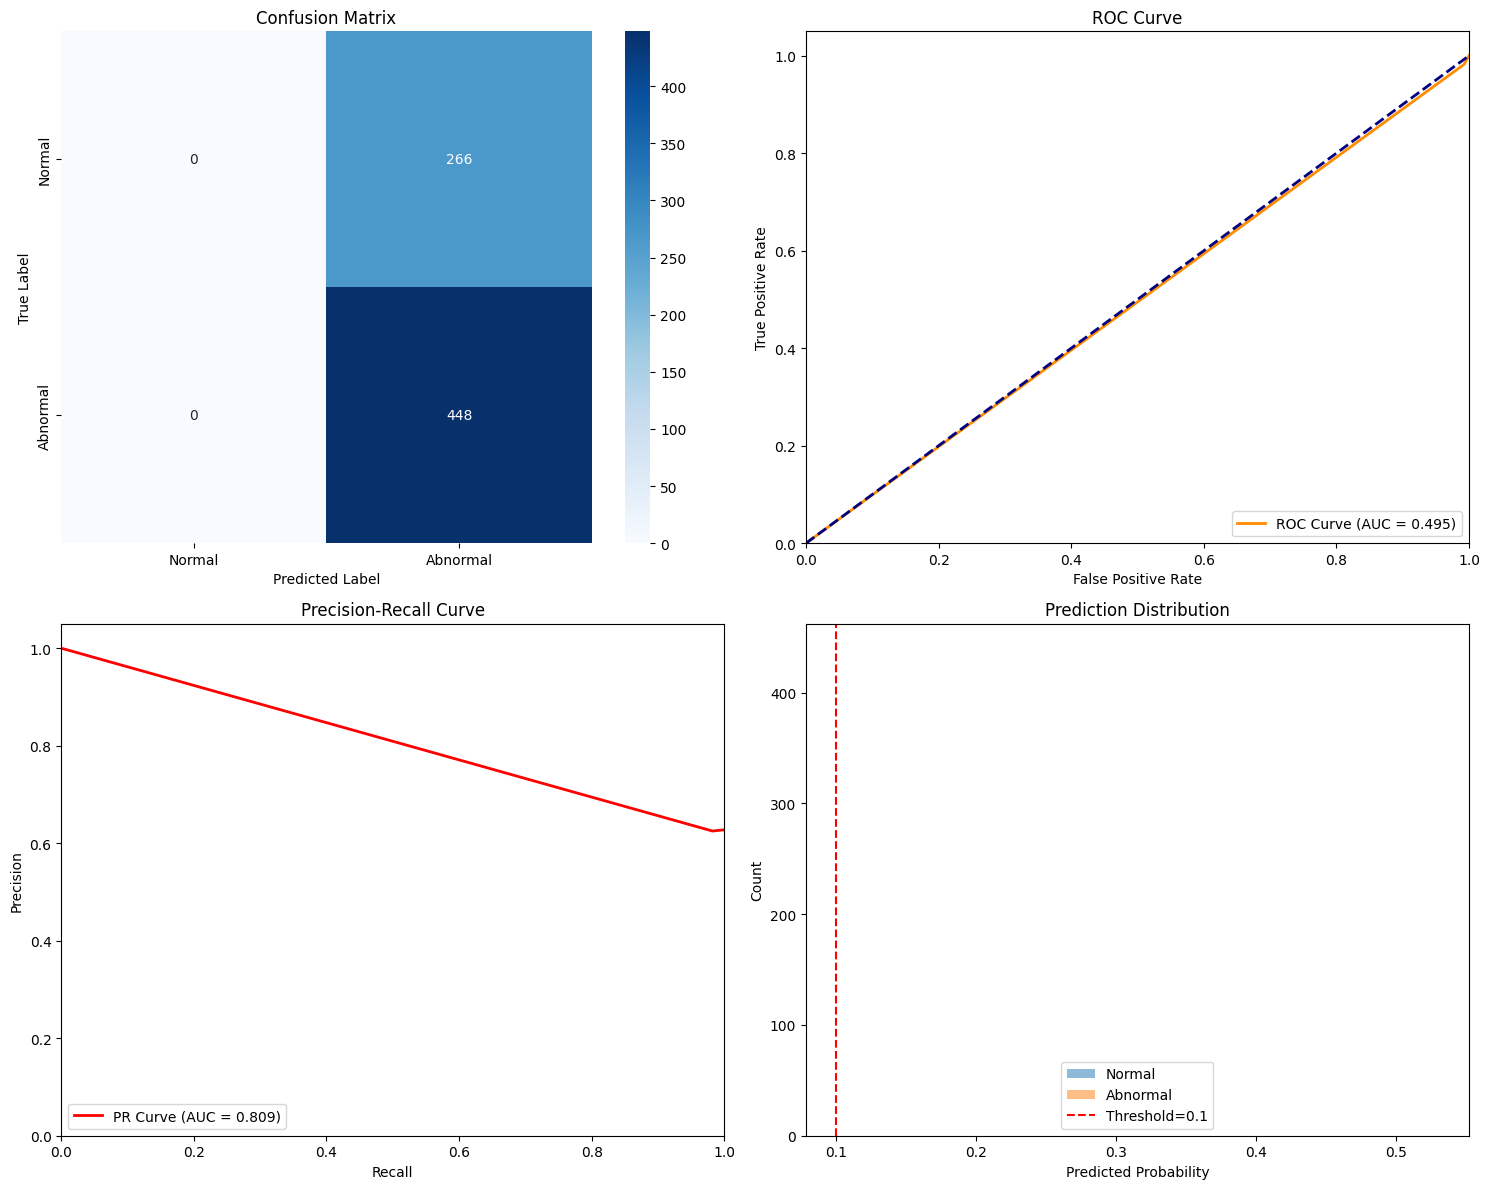


📊 Final Metrics:
Test Accuracy: 0.627
Precision: 0.627
Recall: 1.000
F1-Score: 0.771
ROC AUC: 0.495
PR AUC: 0.809


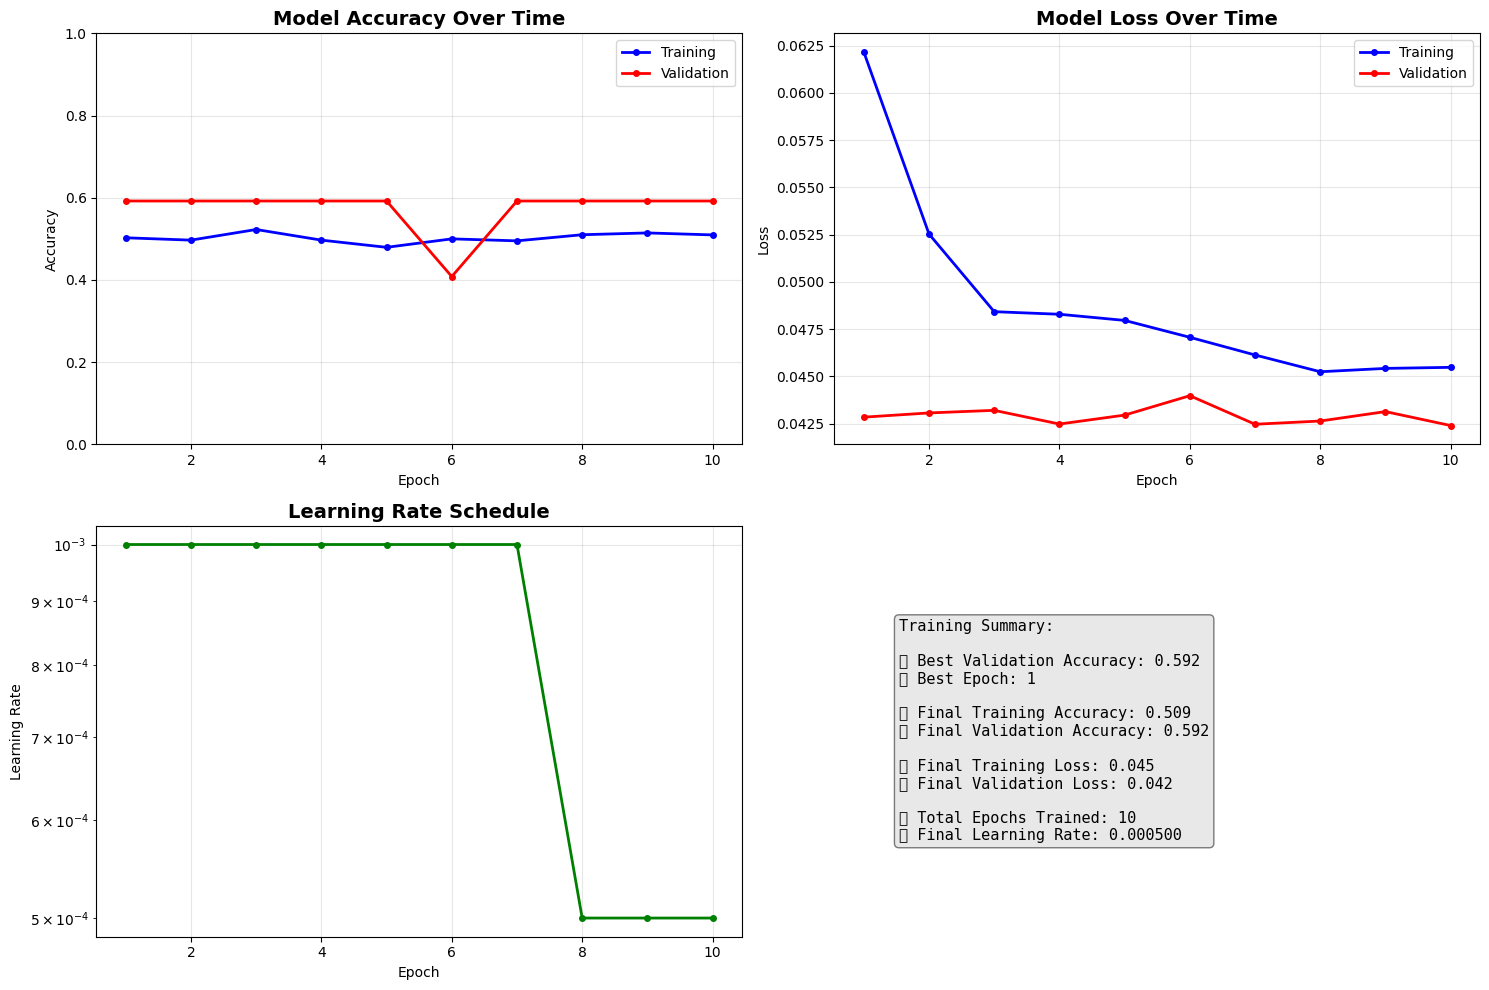


🎉 Training Complete! Final Results:
🎯 Test Accuracy: 0.627
📈 AUC Score: 0.495
🎪 Precision: 0.627
📊 Recall: 1.000
🎭 F1-Score: 0.771
⚖️ Optimal Threshold: 0.100
📅 Total Epochs: 10
💡 Model Performance: Needs Improvement

📝 Recommendations for improvement:
   • Try different data preprocessing techniques
   • Experiment with different augmentation strategies
   • Consider ensemble methods
   • Check data quality and labeling consistency

✅ Model saved as 'best_mammography_model.pth'
📋 Performance metrics saved as 'model_performance.json'
✅ Data loaded successfully!
Training data shape: (2854, 224, 224)
Training labels shape: (2854,)
Test data shape: (714, 224, 224)
Test labels shape: (714,)
Original classes - Train: [0 1 2], Test: [0 1 2]
Binary classes - Train: [0. 1.], Test: [0. 1.]
Corrected data shapes: X_train: (2854, 224, 224, 1), X_test: (714, 224, 224, 1)
Data ranges: X_train [0.008, 0.984], X_test [0.008, 0.984]

📊 Binary Training class distribution:
  Normal (Class 0): 1163 samp

In [20]:
if __name__ == "__main__":
    # Run complete workflow
    print("🏥 Starting Stable Mammography CNN Workflow")
    print("=" * 60)

    try:
        # Main training and evaluation
        model, history, accuracy, auc_score, optimal_threshold = main()

        # Demo predictions if we have data
        try:
            X_train, y_train, X_test, y_test, _ = Load_MammographyData()
            print(f"\n🖼️ Demo predictions...")
            demo_predictions(model, X_test, y_test, num_samples=6, threshold=optimal_threshold)
        except Exception as e:
            print(f"Could not generate demo predictions: {e}")

        print(f"\n🎊 WORKFLOW COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print(f"🎯 Final Test Accuracy: {accuracy:.3f}")
        print(f"📈 Final AUC Score: {auc_score:.3f}")
        print(f"⚖️ Optimal Threshold: {optimal_threshold:.3f}")
        print(f"\n✅ All files saved successfully!")

        if auc_score >= 0.7:
            print(f"🚀 Model shows promising results and is ready for further validation!")
        else:
            print(f"📋 Model needs further optimization before deployment.")

    except Exception as e:
        print(f"❌ Error occurred during training: {str(e)}")
        import traceback
        traceback.print_exc()
        print("\n🔧 Debugging suggestions:")
        print("   • Check data loading and preprocessing")
        print("   • Verify GPU memory availability")
        print("   • Try reducing batch size")
        print("   • Check for data corruption")